In [5]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark import SparkConf

In [6]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [7]:
conf = SparkConf().setMaster("local[*]").set("spark.executer.memory", "2g")

sc = SparkContext(conf=conf)
spark = SparkSession(sc).builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/21 11:11:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/21 11:11:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Problem Statement:
The main objective of this project is to perform a comparative analysis between elite and
 non-elite users based on their interactions and reviews on our platform. This study aims to
 uncover patterns in behavior, preferences, and sentiment, providing insights that can help tailor
 services and engagement strategies more effectively.

### Loading Users Data

In [8]:
df = spark.read.format("csv").option("header", "true").option("multiline","true").load("yelp-dataset-001/yelp_user.csv")
df.printSchema()
df.show(1)


root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- friends: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- fans: string (nullable = true)
 |-- elite: string (nullable = true)
 |-- average_stars: string (nullable = true)
 |-- compliment_hot: string (nullable = true)
 |-- compliment_more: string (nullable = true)
 |-- compliment_profile: string (nullable = true)
 |-- compliment_cute: string (nullable = true)
 |-- compliment_list: string (nullable = true)
 |-- compliment_note: string (nullable = true)
 |-- compliment_plain: string (nullable = true)
 |-- compliment_cool: string (nullable = true)
 |-- compliment_funny: string (nullable = true)
 |-- compliment_writer: string (nullable = true)
 |-- compliment_photos: string (nullable = true)

+--------------------+-----+---------

#### Number of Elite users for Each year

In [14]:
# Find unique values of the "elite" column
unique_elite_values = df.select("elite").distinct()

# Show the unique values
unique_elite_values.show()


+--------------------+
|               elite|
+--------------------+
|2015, 2014, 2013,...|
|2013, 2014, 2009,...|
|2012, 2009, 2015,...|
|2016, 2015, 2017,...|
|2013, 2017, 2014,...|
|2009, 2007, 2008,...|
|2015, 2016, 2010,...|
|2009, 2012, 2013,...|
|2011, 2008, 2009,...|
|          2017, 2010|
|2012, 2008, 2009,...|
|2016, 2015, 2012,...|
|2010, 2015, 2008,...|
|2013, 2015, 2011,...|
|2009, 2011, 2008,...|
|2012, 2017, 2013,...|
|2012, 2010, 2011,...|
|2013, 2010, 2011,...|
|2014, 2009, 2010,...|
|2011, 2017, 2010,...|
+--------------------+
only showing top 20 rows



In [19]:
from pyspark.sql.functions import explode, split, col

# Split the values in the 'elite' column and explode them into separate rows
df2 = df.withColumn("elite_years", split(col("elite"), ",\s*")).select("user_id", explode("elite_years").alias("elite_year"))

# Group by 'elite_year' and count the occurrences
elite_users_by_year = df2.groupBy("elite_year").count().orderBy("elite_year")

# Show the results
elite_users_by_year.show()

+----------+-------+
|elite_year|  count|
+----------+-------+
|      2005|    140|
|      2006|    887|
|      2007|   2363|
|      2008|   3621|
|      2009|   6536|
|      2010|  10485|
|      2011|  13185|
|      2012|  17777|
|      2013|  19841|
|      2014|  20488|
|      2015|  26018|
|      2016|  30856|
|      2017|  34928|
|      None|1265282|
+----------+-------+



### Defining Prblem Statement

In [16]:
from pyspark.sql.functions import when, col

# Add a new column 'elite_flag' with value 1 if 'elite' column is not "None", otherwise 0
df = df.withColumn("elite_flag", when(col("elite") == "None", 0).otherwise(1))

# Show the DataFrame with the new column
df.show(1)


+--------------------+-----+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+----------+
|             user_id| name|review_count|yelping_since|             friends|useful|funny|cool|fans|elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|elite_flag|
+--------------------+-----+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+----------+
|JJ-aSuM4pCFPdkfoZ...|Chris|          10|   2013-09-24|

In [17]:
from pyspark.sql.functions import col

# Count the occurrences of each value in the "elite_flag" column
elite_flag_counts = df.groupBy("elite_flag").count()

# Show the counts
elite_flag_counts.show()


+----------+-------+
|elite_flag|  count|
+----------+-------+
|         1|  60818|
|         0|1265282|
+----------+-------+



### Distribution of Elite vs Non - Elite Users

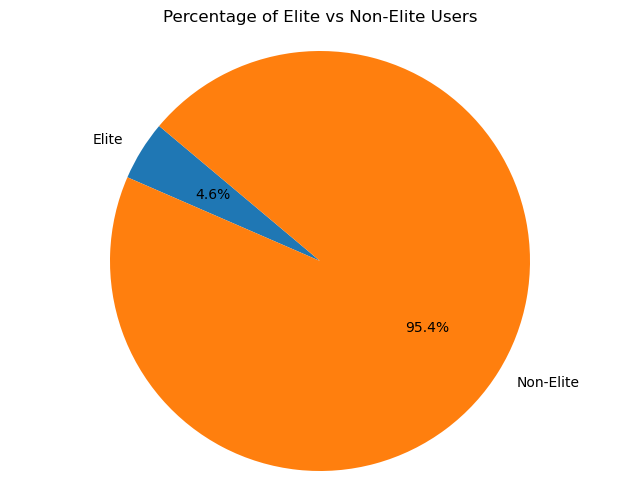

In [18]:
import matplotlib.pyplot as plt

# Calculate the total count
total_count = df.count()

# Calculate the percentages
elite_flag_counts = df.groupBy("elite_flag").count()
elite_flag_counts = elite_flag_counts.withColumn("percentage", (col("count") / total_count) * 100)

# Convert the DataFrame to Pandas for plotting
elite_flag_counts_pd = elite_flag_counts.toPandas()

# Plot the pie chart
labels = ['Elite', 'Non-Elite']
plt.figure(figsize=(8, 6))
plt.pie(elite_flag_counts_pd['percentage'], labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Elite vs Non-Elite Users')
plt.show()
